# 인공신경망, ANN(Artificial Neural Network)
: 생물학적 신경망 뉴런 구조를 모방하여 설계된 시스템

- ANN은 다층의 뉴런으로 구성된 네트워크(입력 데이터를 처리하고 패턴을 인식하여 예측)
- 뉴런 : ANN의 기본 단위, 입력값과 가중치의 합을 계산하고 활성화 함수를 적용하여 출력
- 레이어 : 입력층, 은닉층, 출력층
- 가중치 : 뉴런 간의 연결 강도
- 바이어스(상수부분) : 뉴런에 더해지는 값(기본 상수값)

### 동작원리
1) 순방향 전파(Feedforward) : 입력 데이터를 입력층에 전달하고 각 레이어를 거쳐 출력층까지 전파된다.
2) 손실함수 : 네트워크의 예측값과 실제값의 차이를 측정한다.
3) 역전파 : 손실 함수를 미분하여 각 가중치에 대한 기울기를 계산한다.(오차를 계산받고 기울기를 계산한다.(**가중치 업데이트(학습률에 의해 조정이 된다.) 진행**))
4) 최적화 알고리즘 : 업데이트 방식을 결정한다.(경사하강법, Adam 등)

# 심층신경망(DNN(Deep Neural Network)
: 인공신경망의 한 형태로 여러 은닉층을 포함하고 있는 네트워크

In [54]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks

np.random.seed(42)

In [55]:
data = pd.read_csv('weatherAUS.csv')
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [56]:
# 해당 데이터 셋에는 호주 전역의 다양한 위치에서 10년간 일일 기상 관측치가 기록되어 있다.
# 다음날 비가 올지 안올지 예측한다.

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

<Axes: xlabel='RainTomorrow', ylabel='count'>

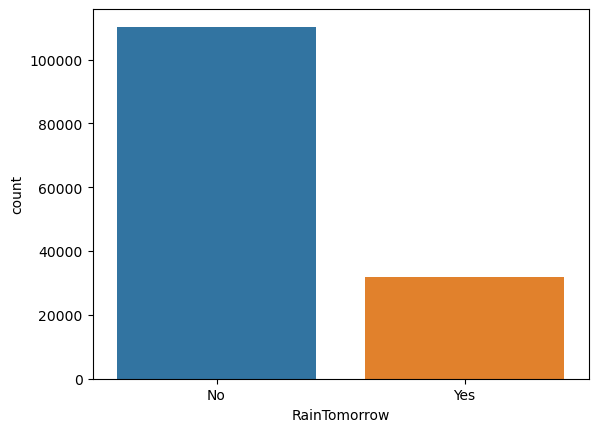

In [58]:
sns.countplot(x=data['RainTomorrow'])

<Axes: >

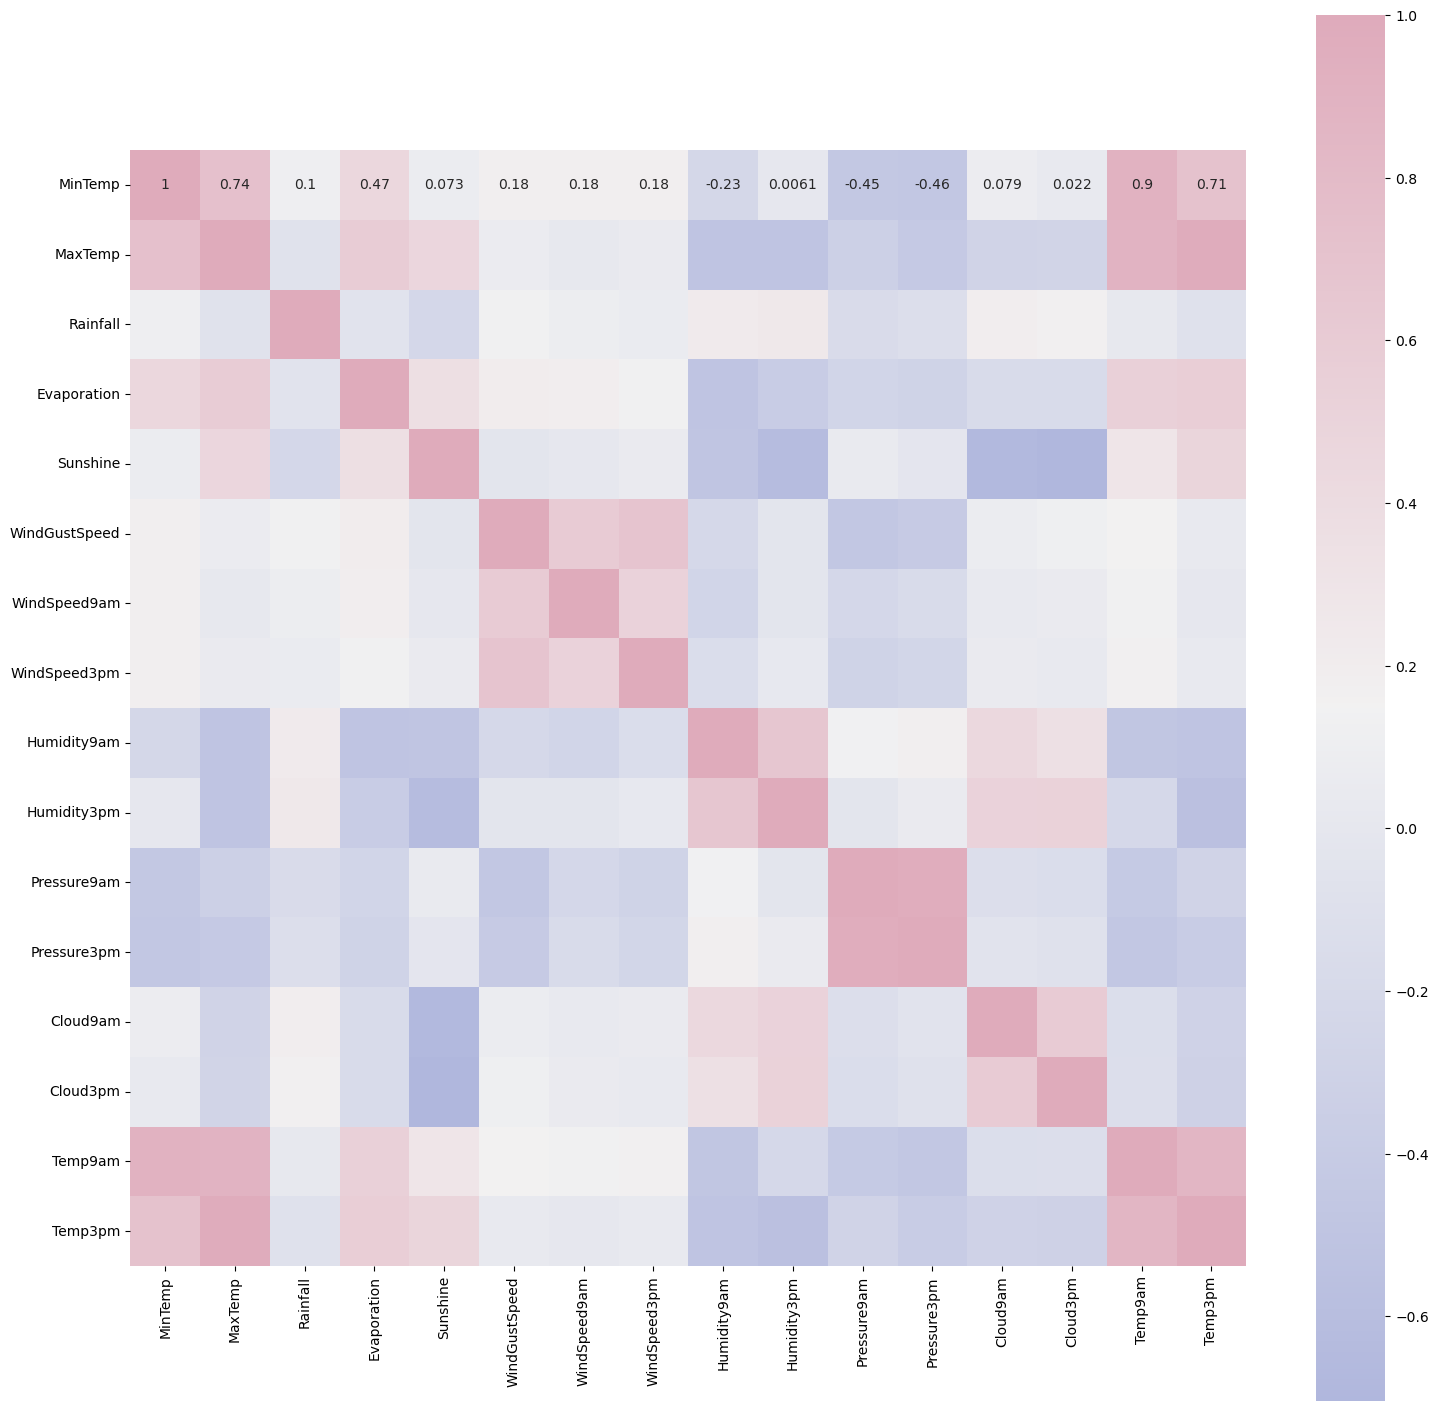

In [59]:
# 히트맵 그리기
numeric_data = data.select_dtypes(include=[float, int])
corrmat = numeric_data.corr()
cmap = sns.diverging_palette(260, -10, s=50, l=75, n=6, as_cmap=True) # Hue 시작값, 끝값, 채도, 밝기, 색상 개수
plt.subplots(figsize=(18, 18))
sns.heatmap(corrmat, cmap=cmap, annot=True, square=True)

In [60]:
# 날짜에 대한 작업
lengths = data['Date'].str.len()
lengths.value_counts()

Date
10    145460
Name: count, dtype: int64

In [61]:
data['Date'] = pd.to_datetime(data['Date'])
data['Date']

0        2008-12-01
1        2008-12-02
2        2008-12-03
3        2008-12-04
4        2008-12-05
            ...    
145455   2017-06-21
145456   2017-06-22
145457   2017-06-23
145458   2017-06-24
145459   2017-06-25
Name: Date, Length: 145460, dtype: datetime64[ns]

In [62]:
data['year'] = data.Date.dt.year
data['year']

0         2008
1         2008
2         2008
3         2008
4         2008
          ... 
145455    2017
145456    2017
145457    2017
145458    2017
145459    2017
Name: year, Length: 145460, dtype: int32

In [63]:
data['Date'] = pd.to_datetime(data['Date'])
data['year'] = data.Date.dt.year

def encode(data, col, max_val): # 신경망 모델에서 연속적인 특성으로 사용하기 위해 만들어진 인코딩
    data[col + '_sin'] = np.sin(2*np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2*np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)
data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)
# month, day에만 encode를 진행

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

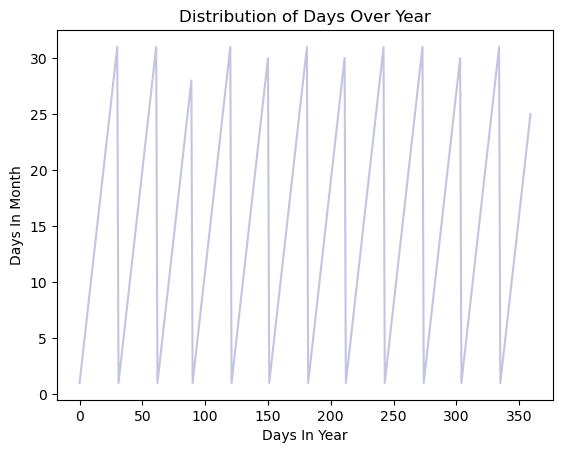

In [64]:
section = data[:360]
tm = section['day'].plot(color='#C2C4E2')
tm.set_title('Distribution of Days Over Year')
tm.set_ylabel('Days In Month')
tm.set_xlabel('Days In Year')

Text(0, 0.5, 'Cosine')

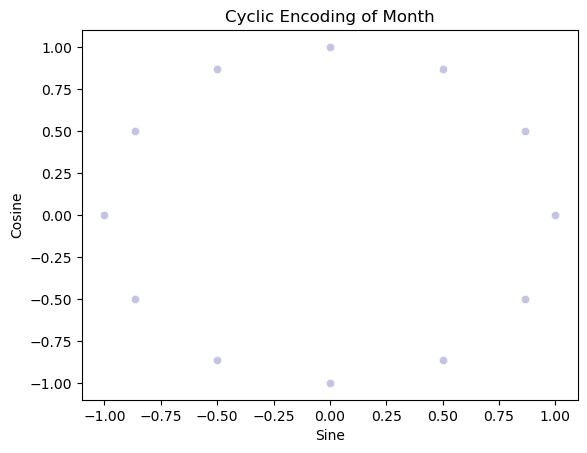

In [45]:
cyclic_month = sns.scatterplot(x='month_sin', y='month_cos', data=data, color='#C2C4E2')
cyclic_month.set_title('Cyclic Encoding of Month')
cyclic_month.set_xlabel('Sine')
cyclic_month.set_ylabel('Cosine')

Text(0, 0.5, 'Cosine')

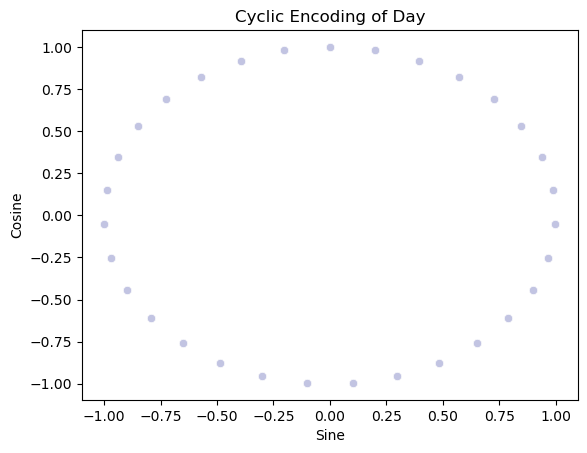

In [46]:
cyclic_month = sns.scatterplot(x='day_sin', y='day_cos', data=data, color='#C2C4E2')
cyclic_month.set_title('Cyclic Encoding of Day')
cyclic_month.set_xlabel('Sine')
cyclic_month.set_ylabel('Cosine')

In [15]:
# 결측값 처리
# 범주형 변수 결측치(categorical)
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print('Categorical Variables : ', object_cols)

Categorical Variables :  ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [16]:
for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 10326
WindDir9am 10566
WindDir3pm 4228
RainToday 3261
RainTomorrow 3267


In [17]:
for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

In [18]:
for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 0
WindDir9am 0
WindDir3pm 0
RainToday 0
RainTomorrow 0


In [19]:
# 숫자형 데이터 결측치 처리
t = (data.dtypes == 'float64')
num_cols = list(t[t].index)

print('Numerical Variables : ', num_cols)

Numerical Variables :  ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [20]:
t[t]

MinTemp          True
MaxTemp          True
Rainfall         True
Evaporation      True
Sunshine         True
WindGustSpeed    True
WindSpeed9am     True
WindSpeed3pm     True
Humidity9am      True
Humidity3pm      True
Pressure9am      True
Pressure3pm      True
Cloud9am         True
Cloud3pm         True
Temp9am          True
Temp3pm          True
month_sin        True
month_cos        True
day_sin          True
day_cos          True
dtype: bool

In [21]:
for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 1485
MaxTemp 1261
Rainfall 3261
Evaporation 62790
Sunshine 69835
WindGustSpeed 10263
WindSpeed9am 1767
WindSpeed3pm 3062
Humidity9am 2654
Humidity3pm 4507
Pressure9am 15065
Pressure3pm 15028
Cloud9am 55888
Cloud3pm 59358
Temp9am 1767
Temp3pm 3609
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [22]:
for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  object        
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  object        
 10  WindDir3pm     145460 non-null  object        
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

Text(0.5, 0, 'Year')

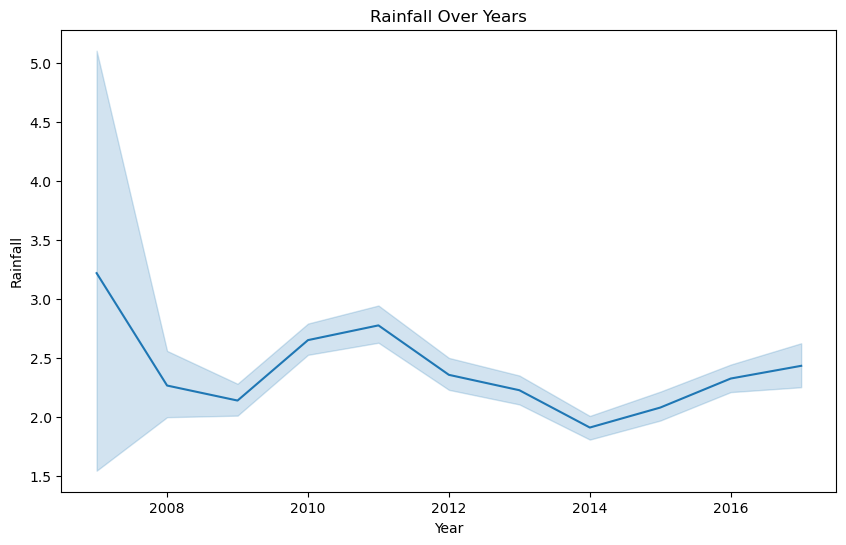

In [24]:
# 날짜, 강수량 그래프
plt.figure(figsize=(10,6))
Time_series = sns.lineplot(x=data['Date'].dt.year, y=data['Rainfall'], data=data)
Time_series.set_title('Rainfall Over Years')
Time_series.set_ylabel('Rainfall')
Time_series.set_xlabel('Year')

Text(0, 0.5, 'WindGustSpeed')

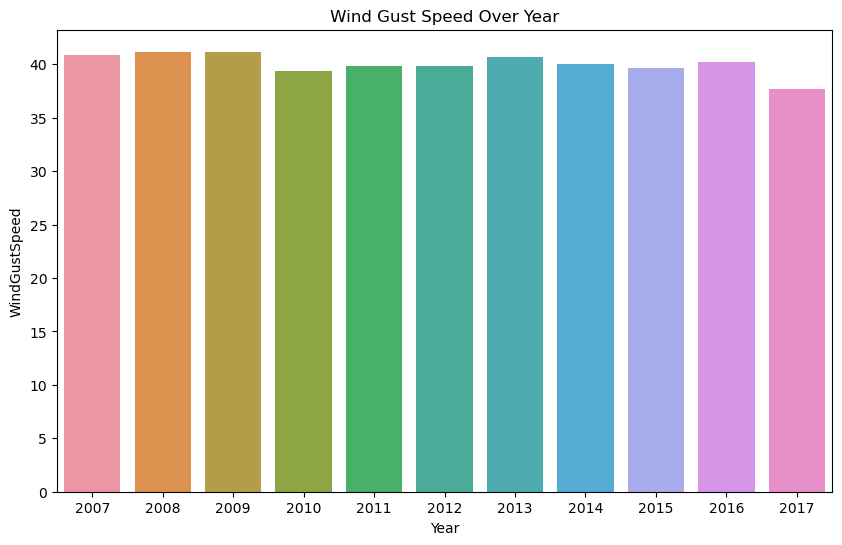

In [25]:
# 바람
plt.figure(figsize=(10, 6))
Days_of_week = sns.barplot(x=data['Date'].dt.year, y=data['WindGustSpeed'], data=data, ci=None)
Days_of_week.set_title('Wind Gust Speed Over Year')
Days_of_week.set_xlabel('Year')
Days_of_week.set_ylabel('WindGustSpeed')

In [26]:
label_encoder = LabelEncoder() # 범주형 변수를 숫자값으로 변환(인코딩 과정)
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  int64         
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  int64         
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  int64         
 10  WindDir3pm     145460 non-null  int64         
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

In [66]:
features = data.drop(['RainTomorrow', 'Date', 'day', 'month'], axis=1)
target = data['RainTomorrow']

In [ ]:
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)

In [51]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
MinTemp,143975.0,12.194034,6.398495,-8.500000,7.600000,1.200000e+01,16.900000,33.900000
MaxTemp,144199.0,23.221348,7.119049,-4.800000,17.900000,2.260000e+01,28.200000,48.100000
Rainfall,142199.0,2.360918,8.478060,0.000000,0.000000,0.000000e+00,0.800000,371.000000
Evaporation,82670.0,5.468232,4.193704,0.000000,2.600000,4.800000e+00,7.400000,145.000000
Sunshine,75625.0,7.611178,3.785483,0.000000,4.800000,8.400000e+00,10.600000,14.500000
WindGustSpeed,135197.0,40.035230,13.607062,6.000000,31.000000,3.900000e+01,48.000000,135.000000
WindSpeed9am,143693.0,14.043426,8.915375,0.000000,7.000000,1.300000e+01,19.000000,130.000000
WindSpeed3pm,142398.0,18.662657,8.809800,0.000000,13.000000,1.900000e+01,24.000000,87.000000
Humidity9am,142806.0,68.880831,19.029164,0.000000,57.000000,7.000000e+01,83.000000,100.000000
Humidity3pm,140953.0,51.539116,20.795902,0.000000,37.000000,5.200000e+01,66.000000,100.000000


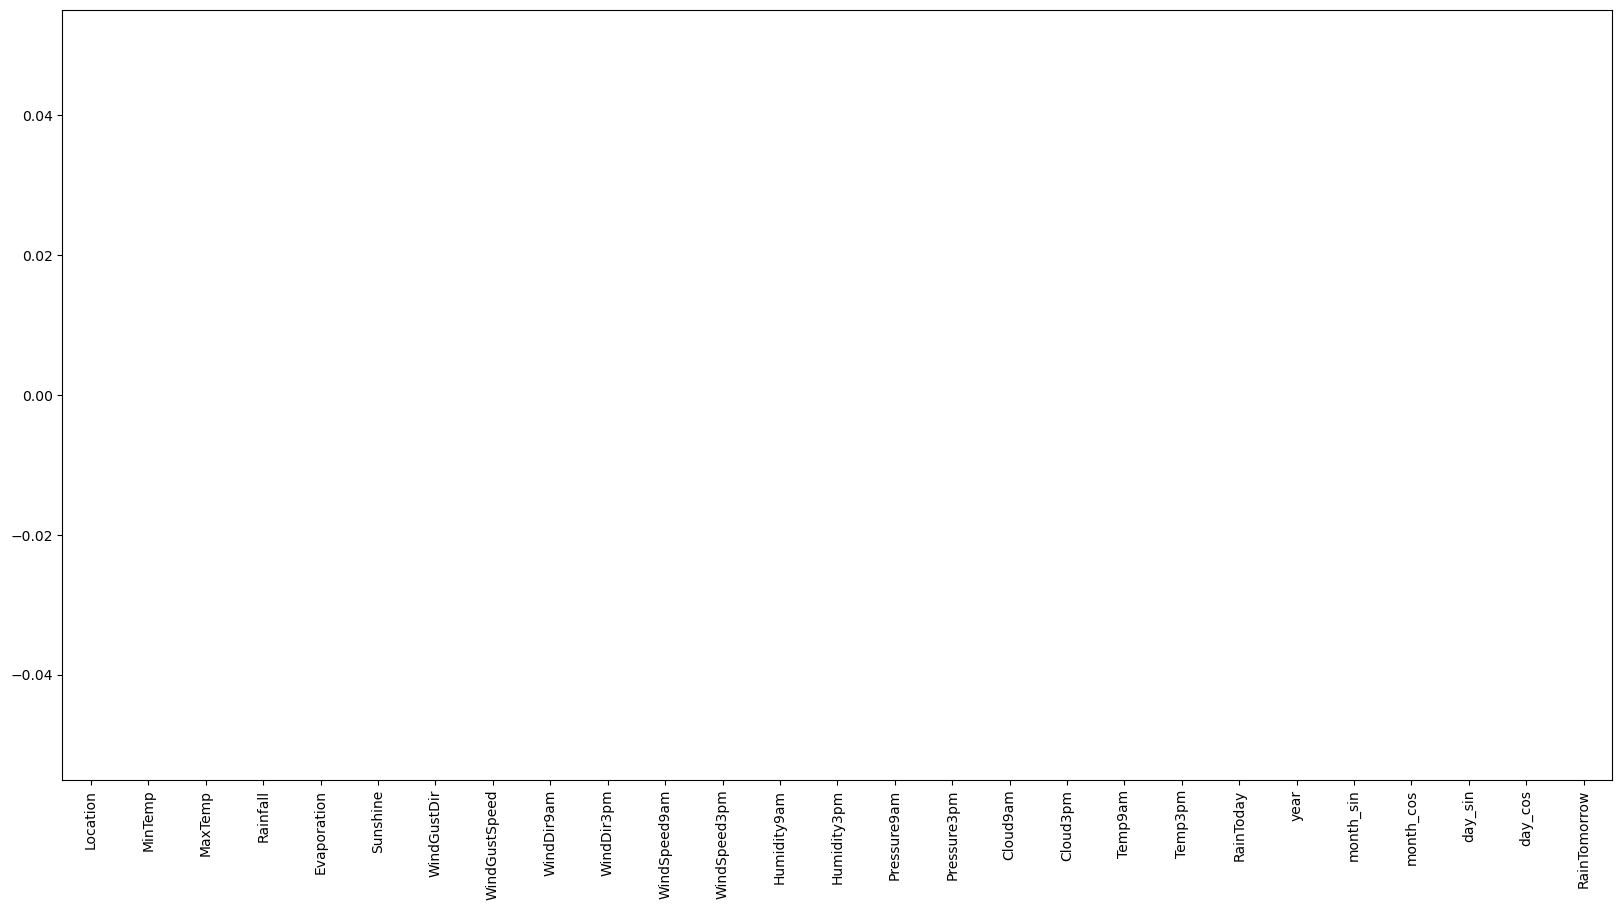

In [65]:
plt.figure(figsize=(20, 10))
sns.boxenplot(data=features)
plt.xticks(rotation=90)
plt.show()

In [52]:
# 이상치 제거 
features['RainTomorrow'] = target

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]

In [32]:
features.shape

(0, 27)

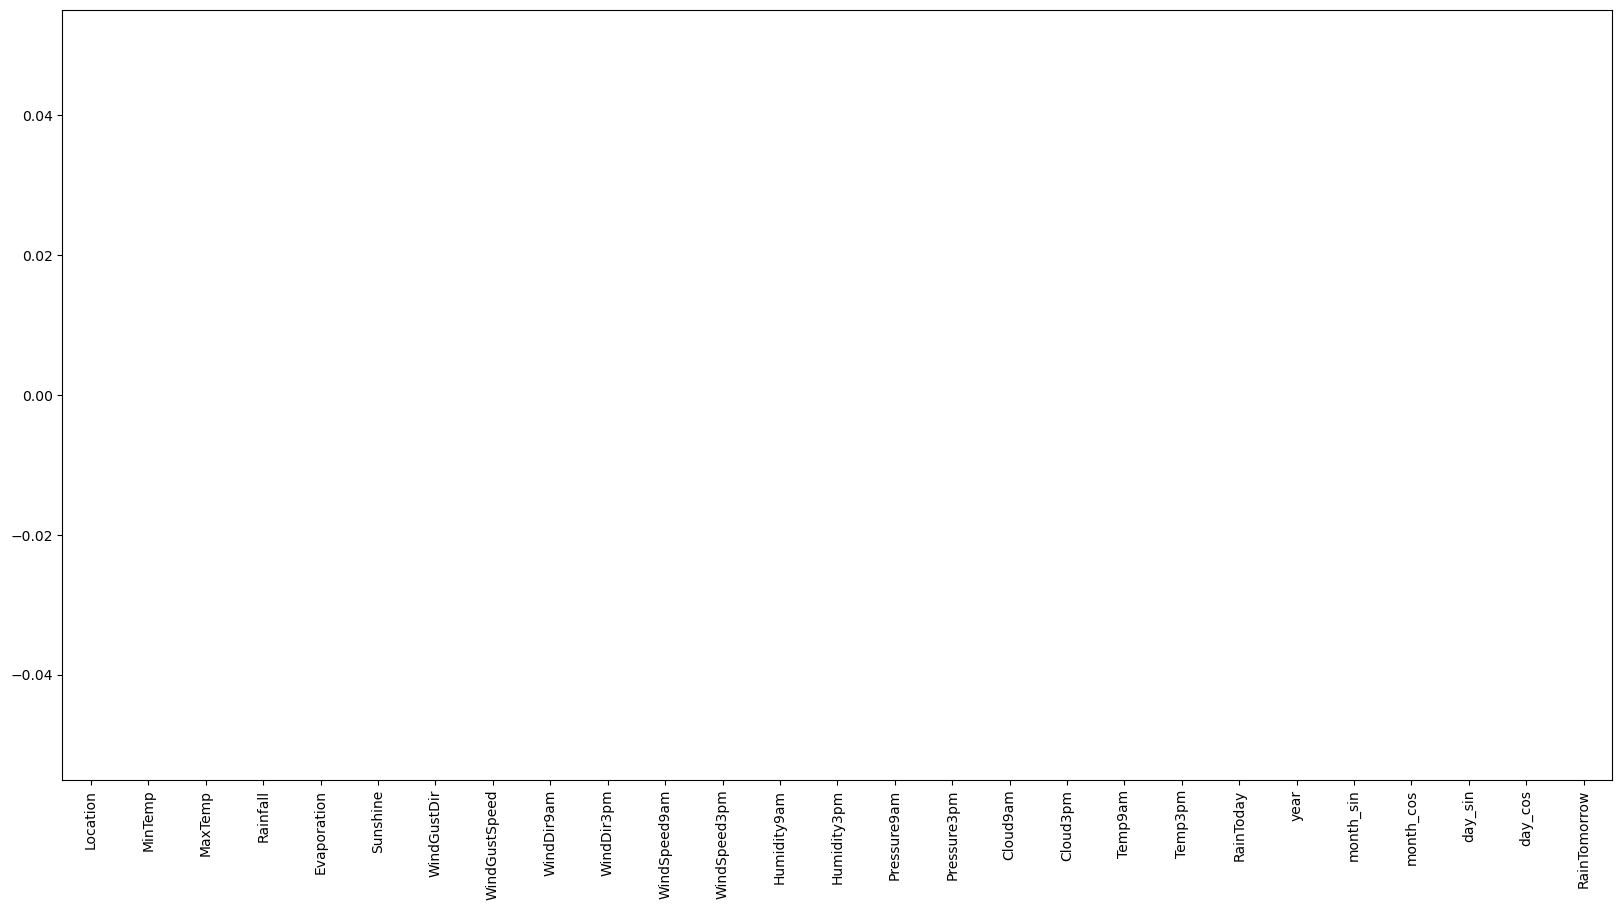

In [33]:
plt.figure(figsize=(20, 10))
sns.boxenplot(data=features)
plt.xticks(rotation=90)
plt.show()

In [93]:
# 이제 인공신경망을 제작하여 작업에 들어간다.

In [ ]:
X = features.drop(['RainTomorrow'], axis=1)
y = features['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X.shape()

In [171]:
early_stoppint = callbacks.EarlyStopping(
    min_delta = 0.001, # 최소 변화량
    patience = 20, # 횟수
    restore_best_weights=True,
) # 에포트 10번 연속으로 0.001이라도 오르지 않으면 멈춘다.

In [ ]:
model = Sequential()

model.add(Dense(units=32, kernel_initializer='uniform', activation='relu', input_dim=26)) # 입력 차원 26
model.add(Dense(units=32, kernel_initializer='uniform', activation='relu')) # kernel_initializer 가중치 행렬 : uniform distribution
model.add(Dense(units=16, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=8, kerner_initializer='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, kernerl_initializer='uniform', activation='sigmoid')) # 이진 분류

In [ ]:
opt = Adam(learning_rate=0.0001) # 최적화함수로 Adam 사용
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuarcy']) # 손실함수 : binary_crossentropy

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=[early_stopping], validation_split=0.2)

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], '#BDE2E2', label='Training Loss')
plt.plot(history_df.loc[:, ['val_loss']], '#C2C4E2', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], '#BDE2E2', label='Training Accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], '#C2C4E2', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = (y_pred>0.5)

In [ ]:
y_pred

In [ ]:
# 정확도 판단을 위해 그래프 그리기
cmap1 = sns.diverging_palette(260, -10, s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12, 8))
cf_matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap=cmap1, annot=True)

In [ ]:
print(classification_report(y_test, y_pred))